In [6]:
import csv
import datetime
import matplotlib
import pandas as pd

df = pd.read_csv(
    'in_lang_docs_all_bibitems.tsv',
    header=None,
    names = ['lang', 'uuid', 'citing_mid', 'cited_mid', 'citing_aid', 'cited_aid', 'bibitem_str'],
    sep='\t',
    low_memory=False,
    quoting=csv.QUOTE_NONE
)

In [2]:
# Basic info

print('--- docs w/ full reference sections ---')
print('Citing docs:\t\t{} ({} w/ MAG ID)'.format(
    df.citing_aid.nunique(),
    df.citing_mid.nunique()
))
print('References:\t\t{} ({} to resolved MAG ID) ({} to resolved arXiv ID)'.format(
    df.uuid.count(),
    df[df.cited_mid.notnull()].cited_mid.count(),
    df[df.cited_aid.notnull()].cited_mid.count()
))
print('Resolved cited docs:\t{} ({} w/ arXiv ID)'.format(
    df.cited_mid.nunique(),
    df.cited_aid.nunique()
))

print()

print('--- only counting "(in <Language>)" citations ---')
print('References:\t\t{} ({} to {} resolved MAG IDs) ({} to {} resolved arXiv IDs)'.format(
    df[df.lang.notnull()].uuid.count(),
    df[df.lang.notnull() & df.cited_mid.notnull()].cited_mid.count(),
    df[df.lang.notnull() & df.cited_mid.notnull()].cited_mid.nunique(),
    df[df.lang.notnull() & df.cited_aid.notnull()].cited_mid.count(),
    df[df.lang.notnull() & df.cited_aid.notnull()].cited_mid.nunique()
))
print('Resolved cited docs:\t{} ({} w/ arXiv ID)'.format(
    df[df.lang.notnull()].cited_mid.nunique(),
    df[df.lang.notnull()].cited_aid.nunique()
))

--- docs w/ full reference sections ---
Citing docs:		18171 (16300 w/ MAG ID)
References:		635154 (290421 to resolved MAG ID) (80310 to resolved arXiv ID)
Resolved cited docs:	183308 (54157 w/ arXiv ID)

--- only counting "(in <Language>)" citations ---
References:		33290 (3734 to 2192 resolved MAG IDs) (340 to 207 resolved arXiv IDs)
Resolved cited docs:	2192 (207 w/ arXiv ID)


In [3]:
# Distribution of languages within reference sections of a single papers
# (takes a bit to calculate)

df_refseclang_dicts = df.groupby(df.citing_aid).agg(
    {
        'lang': lambda x: pd.Series(x).value_counts(dropna=False).to_dict()
    })

In [4]:
# (takes quite a bit)
refsec_cross_ling_ratios = pd.Series(dtype=float, name='cross_ling_ratio')
refsec_sizes = pd.Series(dtype=int, name='refsec_size')
for aid, lang_dict in df_refseclang_dicts['lang'].iteritems():
    ncross = 0
    nmono = 0
    for lang, count in lang_dict.items():
        if pd.notnull(lang):
            ncross += count
        else:
            nmono += count
    refsec_cross_ling_ratios.at[aid] = ncross / (ncross + nmono)
    refsec_sizes.at[aid] = ncross + nmono
df_refsec_cross_ling_ratios = pd.concat([refsec_sizes, refsec_cross_ling_ratios], axis=1)
df_refsec_cross_ling_ratios

,refsec_size,cross_ling_ratio
0704.0046,13,0.076923
0704.0091,22,0.045455
0704.0130,40,0.025000
0704.0180,15,0.066667
0704.0260,9,0.111111
...,...,...
solv-int9910002,7,0.285714
solv-int9910008,15,0.066667
solv-int9912010,23,0.043478
solv-int9912011,5,0.600000


In [5]:
df_refsec_cross_ling_ratios[df_refsec_cross_ling_ratios.refsec_size >= 2].cross_ling_ratio.describe()

count    18162.000000
mean         0.082856
std          0.097038
min          0.000695
25%          0.030303
50%          0.050000
75%          0.095238
max          1.000000
Name: cross_ling_ratio, dtype: float64

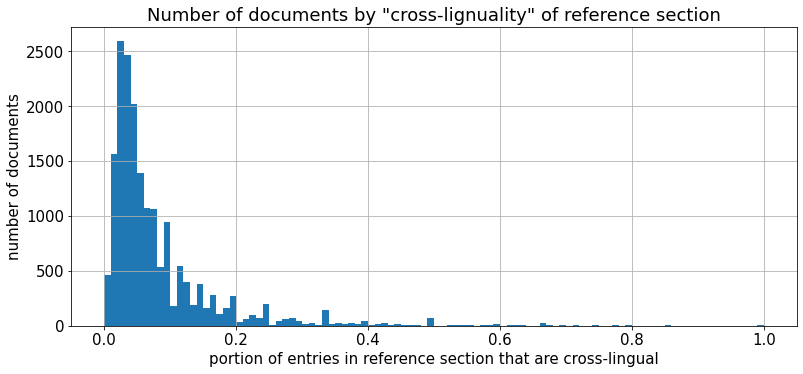

In [57]:
matplotlib.rcParams['font.size'] = 15
ax = df_refsec_cross_ling_ratios[df_refsec_cross_ling_ratios.refsec_size >= 2].cross_ling_ratio.hist(
    bins=100,
    figsize=(13,5.5),
)
matplotlib.pyplot.title('Number of documents by "cross-lignuality" of reference section')
ax.set_xlabel("portion of entries in reference section that are cross-lingual")
ax.set_ylabel("number of documents")
ax.figure.savefig('cross_ling_ratios_of_refsecs_w_min_size_3.pdf', dpi=300)
ax.figure.savefig('cross_ling_ratios_of_refsecs_w_min_size_3.png', dpi=300)

In [14]:
# load in arXiv metadata
# (takes quite a bit of time)

dparser = lambda x: datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')
df_mtd = pd.read_csv(
    'in_lang_cleaned_extended.tsv',
    header=None,
    names = ['uuid', 'lang', 'aid', 'published', 'category', 'journal_ref', 'bibitem_str'],
    sep='\t',
    parse_dates=['published'],
    date_parser=dparser,
    low_memory=False,
    quoting=csv.QUOTE_NONE
)
disc_map = {  # see: https://arxiv.org/category_taxonomy
    'math': 'math',
    'cond-mat': 'phys',
    'math-ph': 'phys',
    'physics': 'phys',
    'cs': 'cs',
    'hep-th': 'phys',
    'nlin': 'phys',
    'gr-qc': 'phys',
    'hep-ph': 'phys',
    'astro-ph': 'phys',
    'quant-ph': 'phys',
    'nucl-th': 'phys',
    'q-fin': 'other',
    'hep-ex': 'phys',
    'stat': 'other',
    'nucl-ex': 'phys',
    'q-alg': 'math',
    'q-bio': 'other',
    'solv-int': 'phys',
    'chao-dyn': 'phys',
    'hep-lat': 'phys',
    'funct-an': 'math',
    'patt-sol': 'phys',
    'dg-ga': 'other',
    'alg-geom': 'math',
    'cmp-lg': 'cs',
    'adap-org': 'phys',
    'econ': 'other',
    'eess': 'other',
    'acc-phys': 'phys',
    'comp-gas': 'cs'
}

ppr_category = pd.Series(dtype=str, name='category')
ppr_published = pd.Series(dtype='datetime64[ns]', name='published')
for rovv in df_mtd.iterrows():
    row = rovv[1]
    ppr_category.at[row.aid] = disc_map[row.category.split('.')[0]]
    ppr_published.at[row.aid] = row.published

# df_mtd['category'] = df_mtd['category'].apply(lambda x: disc_map[x.split('.')[0]])
# 
# df_pubcat = df_mtd[['aid', 'published', 'category']].groupby('aid').agg(
#     {'published': lambda x: x,
#      'category': lambda x: x}
# )
# df_mtd[['aid', 'published', 'category']][df_mtd.aid == 'solv-int9912011']
# df_pubcat.reset_index()

In [15]:
# extend
df_refsec_cross_ling_ratios_ext = pd.concat(
    [refsec_sizes,
     refsec_cross_ling_ratios,
     ppr_category,
     ppr_published], axis=1
)
df_refsec_cross_ling_ratios_ext

,refsec_size,cross_ling_ratio,category,published
0704.0046,13,0.076923,phys,2007-04-01 16:37:36
0704.0091,22,0.045455,math,2007-04-01 15:17:36
0704.0130,40,0.025000,math,2007-04-02 06:25:15
0704.0180,15,0.066667,phys,2007-04-02 12:40:00
0704.0260,9,0.111111,math,2007-04-03 19:16:48
...,...,...,...,...
solv-int9910002,7,0.285714,phys,1999-10-08 07:40:53
solv-int9910008,15,0.066667,phys,1999-10-18 16:16:47
solv-int9912010,23,0.043478,phys,1999-12-15 19:15:16
solv-int9912011,5,0.600000,phys,1999-12-16 16:05:14


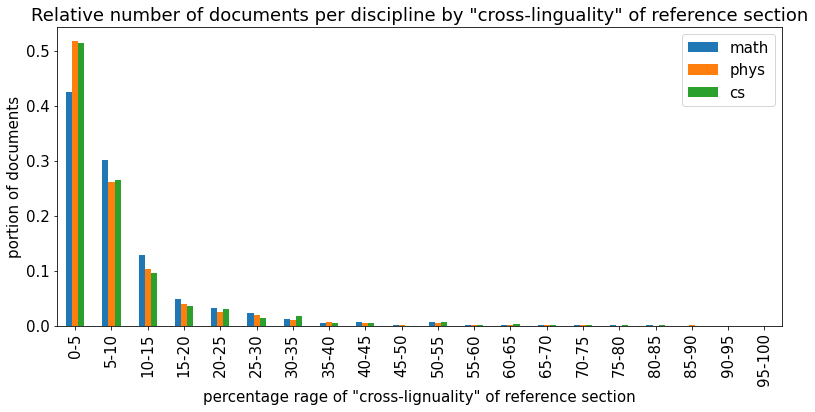

In [64]:
# calculate cross linguality level cross-section across domains

total_cat_counts = df_refsec_cross_ling_ratios_ext.category.value_counts().to_dict()

phys_cross_ling_ratios = pd.Series(dtype=float, name='phys')
math_cross_ling_ratios = pd.Series(dtype=float, name='math')
cs_cross_ling_ratios = pd.Series(dtype=float, name='cs')
other_cross_ling_ratios = pd.Series(dtype=float, name='other')
cross_ling_ratios = {
    'phys': phys_cross_ling_ratios,
    'math': math_cross_ling_ratios,
    'cs': cs_cross_ling_ratios,
    'other': other_cross_ling_ratios
}

step = 5
for min_ratio in range(0, 100, step):
    min_r = min_ratio / 100
    max_r = (min_ratio+step) / 100
    very_cross_ling_cat_counts = df_refsec_cross_ling_ratios_ext[
        # (df_refsec_cross_ling_ratios_ext.refsec_size > 2) & \
        (df_refsec_cross_ling_ratios_ext.cross_ling_ratio >= min_r) &\
        (df_refsec_cross_ling_ratios_ext.cross_ling_ratio < max_r)].category.value_counts().to_dict()
    for disc in set(disc_map.values()):
        cross_ling_ratios[disc].at[
            '{}-{}'.format(min_ratio, min_ratio+step)
        ] = very_cross_ling_cat_counts.get(disc, 0) / total_cat_counts[disc]
df_refsec_cross_ling_crosssecs = pd.concat(
    [math_cross_ling_ratios,
     phys_cross_ling_ratios,
     cs_cross_ling_ratios,
     # other_cross_ling_ratios
    ], axis=1
)
# xlabel: relative number of documents in category
# ylabel: filter ratio of cross-lingual citations
matplotlib.rcParams['font.size'] = 15
ax = df_refsec_cross_ling_crosssecs.plot(
    kind='bar',
    # marker='.',
    # style='--',
    figsize=(13,5.5),
    title='Relative number of documents per discipline by "cross-linguality" of reference section'
)
ax.set_xlabel('percentage rage of "cross-lignuality" of reference section')
ax.set_ylabel("portion of documents")
# ax.figure.savefig('cross_ling_ratio_distribution_across_disciplines_w_min_size_3.pdf', dpi=300)
# ax.figure.savefig('cross_ling_ratio_distribution_across_disciplines_w_min_size_3.png', dpi=300)

In [74]:
print('-----all-----')
print(df_refsec_cross_ling_ratios.cross_ling_ratio.describe())
for disc in ['math', 'phys', 'cs']:
    print(f'-----{disc}-----')
    print(df_refsec_cross_ling_ratios_ext[df_refsec_cross_ling_ratios_ext.category == disc].describe())

-----all-----
count    18171.000000
mean         0.083310
std          0.099137
min          0.000695
25%          0.030303
50%          0.050000
75%          0.095238
max          1.000000
Name: cross_ling_ratio, dtype: float64
-----math-----
       refsec_size  cross_ling_ratio
count  7888.000000       7888.000000
mean     29.353955          0.090465
std      37.796036          0.103380
min       1.000000          0.000735
25%      15.000000          0.034483
50%      23.000000          0.055556
75%      35.000000          0.100000
max    1637.000000          1.000000
-----phys-----
       refsec_size  cross_ling_ratio
count  8989.000000       8989.000000
mean     39.614974          0.077796
std      53.502744          0.095330
min       1.000000          0.000695
25%      17.000000          0.027027
50%      28.000000          0.047619
75%      44.000000          0.090909
max    1439.000000          1.000000
-----cs-----
       refsec_size  cross_ling_ratio
count  1019.000000       